Project 3 - Behavioural Cloning - Report. Vilas Chitrakaran. Feb 2017

## Executive Summary

This report describes my implementation of a convolutional neural network (CNN) to predict steering angles from a set of training images acquired from a driving simulator. The CNN is a slightly modified Keras implementation of [this paper](https://arxiv.org/abs/1604.07316) from NVIDIA Corporation. The trained model successfully steered the simulated car around track-1 of the beta-simulator provided as part of this project.

This report describes results from training performed using the sample dataset provided by Udacity. As demonstrated in [this video](https://youtu.be/WBbD0AUHC_c), the network generates smooth steering angles on track 1. Also see [this video](https://www.youtube.com/watch?v=-qglBedY3i4) for front camera view. Although not described here, I have also successfully trained the network to work on this track using a training set consisting of images from both tracks 1 and 2 that I acquired by manually driving the car.

Overhead Camera


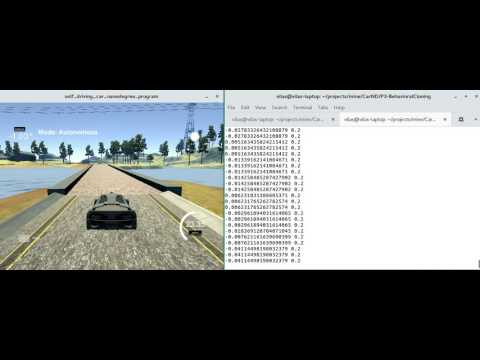

Front Camera (Apologies for the low quality)


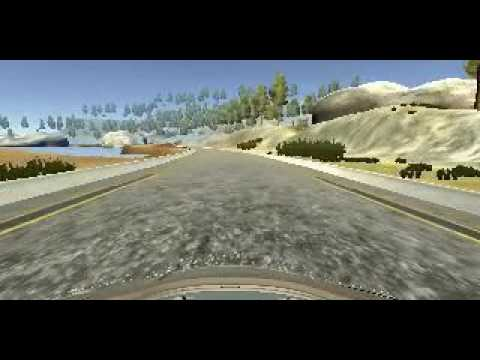

In [1]:
#=====================================================================
# Demo video of autonomous steering control using the network described in this report
import IPython
print('Overhead Camera')
vid = IPython.display.YouTubeVideo("WBbD0AUHC_c")
IPython.display.display(vid)
print('Front Camera (Apologies for the low quality)')
vid = IPython.display.YouTubeVideo("-qglBedY3i4")
IPython.display.display(vid)

### Submission

The following files accompany this report:
* `model.py`: Script used to create and train the CNN. This report describes how the model was developed and trained.
* `model.h5`: The trained model, created by the above script. 
* `drive.py`: Script used to drive the car using the trained model above.

### Usage

* Open a terminal and start the simulator: `./beta_simulator.x86_64`

* Open another terminal and run the following to drive the simulated car autonomously: `python drive.py model.h5`

* The simulated car will now start moving. Verify that the car stays on the road at all times

## Model Development

### Loading the training set
I first examined the organisation of training data which consisted of a csv file and a set of images. The following code loads and prints out some basic information about what constitutes the (Udacity-provided) training set.  

In [2]:
#===============================================================================================
# Load the input data meta file
import os
import csv

# Read the CSV file in
# note: first line of the CSV file is the header. Add a column for flip and l/c/r image input to use
samples_dir = './sample_data'
samples = []
with open(samples_dir+'/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        line.extend('0') # add a column for flip flag
        line.extend('c') # add a column for left/right/center image flag
        samples.append(line)

samples[0][-2] = 'flip' # flip flag
samples[0][-1] = 'input' # input image flag

print('Number of samples: ', len(samples)-1)
print('Data format: ', samples[0]) 

# Don't need the header anymore
samples.pop(0);


Number of samples:  8036
Data format:  ['center', 'left', 'right', 'steering', 'throttle', 'brake', 'speed', 'flip', 'input']


### Training set visualisation

OK, so we basically have images from three cameras (center, left, right) and corresponding steering angles captured at roughly 10 Hz. As I was reading the csv file in, I also added flags to specify which one of the three images to use ('input') at any instant of time, and whether to horizontally flip the image and the steering angle ('flip'). The following code was then utilised to visualise the distribution of steering angles in the training set.

Training images have:  160 rows, 320 columns, 3 channels
Steering range: ( -0.942695 , 1.0 )


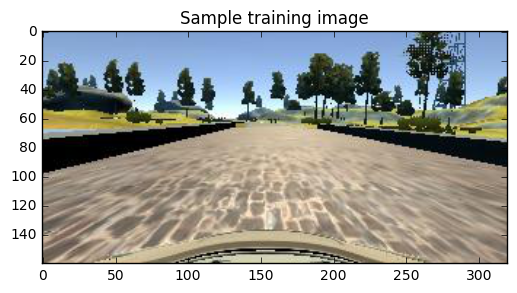

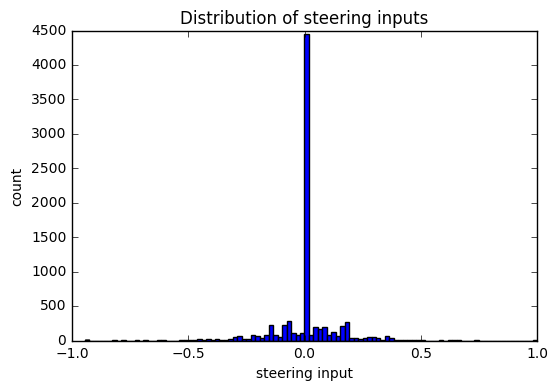

In [3]:
#===============================================================================================
# Visualise steering distributions
# Note: Not sure what units they are in. If it's 'angle', it's most likely to be radians
# Note: NVidia paper uses inverse radius 1/r for steering input

import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def read_image(filename):
    image = cv2.imread(filename)
    return cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

def plot_steering_distribution(dataset, title):
    steering = [np.float32(x[3]) for x in dataset]
    print('Steering range: (', min(steering), ',', max(steering), ')')
    plt.figure()
    plt.hist(steering, bins=101)
    plt.xlabel('steering input')
    plt.ylabel('count')
    plt.title(title)
    plt.show()

sample_image = read_image(samples_dir+'/IMG/'+samples[0][0].split('/')[-1])
imrows, imcols, imch = sample_image.shape

print('Training images have: ', imrows, 'rows,', imcols, 'columns,', imch, 'channels')
plt.figure()
plt.imshow(sample_image)
plt.title('Sample training image')
plot_steering_distribution(samples, 'Distribution of steering inputs')


### Training set augmentation

As is apparent above, the data set is heavily skewed towards images corresponding to zero steering angle. We want a good distribution of images where the the car is being positively steered towards the center of the road such that the model can be trained to maintain the car within the boundaries of the road. Therefore, using the code below, I culled away most of the zero-steering data points and further augmented the data set by adding horizontally flipped images (and flipping corresponding steering angles), and images from the left and right camera with a corresponding steering adjustment. __NOTE__ that the following code only sets the flag. The actual flipping and camera selection takes place in the generator routine presented later. 

Number of samples after cull: 3893
Steering range: ( -0.942695 , 1.0 )


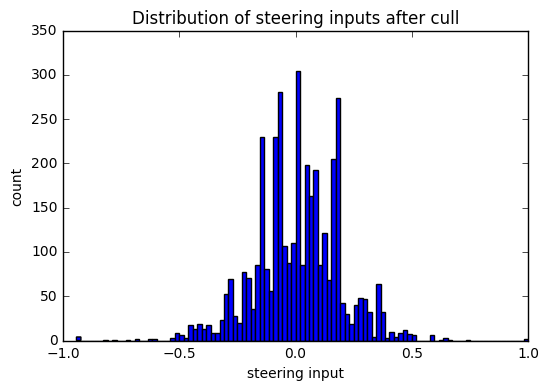

Number of samples after augmentation: 9185


In [4]:
#===============================================================================================
# Preprocess input data to make it more useful

import random
import copy

# reduce the large set of instances where steering is zero or close to.
def cull_steering_range(samples, keep_ratio = 0.1, min_steer=-0.001, max_steer=0.001):
    steer_active = [row for row in samples if (min_steer > float(row[3]) or float(row[3]) > max_steer)]
    steer_inactive = [row for row in samples if (min_steer <= float(row[3]) and float(row[3]) <= max_steer)]
    random_steer_inactive = random.sample(steer_inactive, int(keep_ratio * len(steer_inactive)))
    steer_active.extend(random_steer_inactive)
    return steer_active

# augment data by using left images and damping left steers and enhancing right steers
def set_left_image_flag(samples, select_ratio = 0.1):
    selected = random.sample(samples, int(select_ratio * len(samples)))
    for row in selected:
        row[8] = 'l' # set the flag here. Select image online within the generator
    return selected

# augment data by using right images and damping right steers and enhancing left steers
def set_right_image_flag(samples, select_ratio = 0.1):
    selected = random.sample(samples, int(select_ratio * len(samples)))
    for row in selected:
        row[8] = 'r' # set the flag here. Select image online within the generator
    return selected

# augment data with flipped images and angles
def set_flip_flag(samples, flip_ratio=0.5):
    selected = random.sample(samples, int(flip_ratio * len(samples)))
    for row in selected:
        row[7] = '1' # set the flag here. Flip the image online within the generator
    return selected

culled_samples = cull_steering_range(samples,keep_ratio=0.05)
print('Number of samples after cull:', len(culled_samples))
plot_steering_distribution(culled_samples, 'Distribution of steering inputs after cull')

# augment dataset by flipping images and utilising side cameras
valid_samples = culled_samples
valid_samples.extend(set_flip_flag(copy.deepcopy(culled_samples), flip_ratio=0.95))
valid_samples.extend(set_left_image_flag(copy.deepcopy(culled_samples), select_ratio = 0.1))
valid_samples.extend(set_right_image_flag(copy.deepcopy(culled_samples), select_ratio = 0.1))
print('Number of samples after augmentation:', len(valid_samples))


### Splitting into training and validation sets

Although the histogram above only shows steering angle distribution after culling, we do have a balanced training set now; actual augmentation of the data set happens later in the generator. The data set is now broken into training and validation sets; 20% of the set was allocated to validation. Code below: 

In [5]:
#===============================================================================================
# split data into training and validation sets
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

shuffle(samples)
train_samples, validation_samples = train_test_split(valid_samples, test_size=0.2)
print('Number of training samples:', len(train_samples))
print('Number of validation samples:', len(validation_samples))

Number of training samples: 7348
Number of validation samples: 1837


### Generator

The generator routine below avoids the need to carry the entire data set in memory during the training process. Instead we process them on the fly as required. As mentioned earlier, we also select the camera image to use and flip the images as per the flags set in the data augmentation step.

In [6]:
#===============================================================================================
# Generator function to avoid loading all images and data into memory

def flip_image(image):
    image = np.fliplr(image)
    return image

def generate_batch(samples, damp_angle=0.2, batch_size=32):
    num_samples = len(samples)
    while 1:
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            angles = []
            for sample in batch_samples:

                # select image
                if sample[8] is 'c':
                    image = read_image(samples_dir+'/IMG/'+sample[0].split('/')[-1])
                    angle = np.float32(sample[3])
                elif sample[8] is 'l':
                    image = read_image(samples_dir+'/IMG/'+sample[1].split('/')[-1])
                    angle = damp_angle + np.float32(sample[3])
                elif sample[8] is 'r': 
                    image = read_image(samples_dir+'/IMG/'+sample[2].split('/')[-1])
                    angle = -damp_angle + np.float32(sample[3])

                # flip image
                if sample[7] is '1':
                    image = flip_image(image) 
                    angle = -1.*angle
 
                images.append(image) 
                angles.append(angle)
        
            X_train = np.array(images)
            y_train = np.array(angles)
            yield shuffle(X_train, y_train)


A quick sanity check to ensure that the generator works as I expect.

Batch: 0 , num images:  32 , num angles: 32
Batch: 1 , num images:  32 , num angles: 32
Batch: 2 , num images:  32 , num angles: 32
Batch: 3 , num images:  32 , num angles: 32


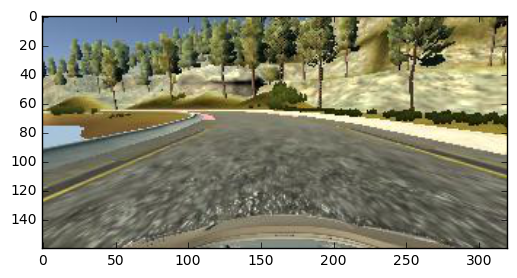

In [7]:
#===============================================================================================
# Test the generator
ntest = 4
for i in range(ntest):
    image, angle = next(generate_batch(train_samples, damp_angle=0.2, batch_size=32))
    print('Batch:', i,', num images: ', len(image), ', num angles:', len(angle))

plt.figure()
plt.imshow(image[0])


### Network Architecture

I started by implementing the convolutional neural network proposed in the NVIDIA paper. After some initial testing, I modified the architecture to introduce the following:
* Max-pooling between convolutional layers 
* ReLU activation on the final three convolutional layers
* A dropout before the fully connected layers

The max-pooling reduces spatial extent of feature maps and helps prevent overfitting (used instead of stride=2 as suggested in the paper). ReLU activations help make the network robust to any nonlinearity in the input-output relationship. The dropout layer again makes the network robust to overfitting. With the limited size of the training dataset that we have got, overfitting can be an issue.

A cropping layer takes the input camera images and crops out areas from the top (sky) and bottom (bonnet) that are largely irrelevant to training. This also reduces computational load as the images are now smaller. The following layer normalises the image such that pixel values are in the range (-1,1). This helps with better numerical conditioning of the optimisation problem.


In [8]:
#===============================================================================================
# Define network
# We implement CNN architecture from the nvidia paper with a few modifications 
# (added relu activations, max-pooling and drop-outs)

from keras.models import Sequential
from keras.layers import Cropping2D
from keras.layers.core import Lambda, Dense, Activation, Flatten, Dropout
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D

# generate the neural network
model = Sequential()
model.add(Cropping2D(cropping=((60,20), (0,0)), input_shape=(imrows, imcols, imch))) # crop to track
model.add(Lambda(lambda x: x/127.5 - 1.)) # normalise
model.add(Convolution2D(24, 5, 5, activation=None, subsample=(1,1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Convolution2D(36, 5, 5, activation=None, subsample=(1,1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Convolution2D(48, 5, 5, activation='relu', subsample=(1,1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Convolution2D(64, 3, 3, activation='relu', subsample=(1,1)))
model.add(Convolution2D(64, 3, 3, activation='relu', subsample=(1,1)))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(100))
model.add(Dense(50))
model.add(Dense(10))
model.add(Dense(1))


Using TensorFlow backend.


A textual visualisation of the network architecture follows:

In [9]:
#===============================================================================================
# print a summary of the NN
model.summary()


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
cropping2d_1 (Cropping2D)        (None, 80, 320, 3)    0           cropping2d_input_1[0][0]         
____________________________________________________________________________________________________
lambda_1 (Lambda)                (None, 80, 320, 3)    0           cropping2d_1[0][0]               
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 76, 316, 24)   1824        lambda_1[0][0]                   
____________________________________________________________________________________________________
maxpooling2d_1 (MaxPooling2D)    (None, 38, 158, 24)   0           convolution2d_1[0][0]            
___________________________________________________________________________________________

### Training

We are ready to train the model. I used meta-parameters mostly as suggested by the course notes. A large batch size (> 64) didn't seem to work on my poor old laptop with a fairly dated NVIDIA card anyway. After experimenting with a range of epochs, it was found that not much improvement was seen for epochs > 5. As mentioned earlier, the generator chooses images from the left/center/right cameras on the fly. If one of the side cameras are chosen, the steering angle is modified so that 
* When using the left side camera image, the steering angle is softened for left steers and enhanced for right steers
* When using the right side camera image, the steering angle is softened for right steers and enhanced for left steers

In [11]:
#===============================================================================================
# compile and train the model using the generator function
EPOCHS = 5
BATCH_SIZE = 32
SIDECAM_STEER_OFFSET = 0.15

train_generator = generate_batch(train_samples, damp_angle=SIDECAM_STEER_OFFSET, batch_size=BATCH_SIZE)
validation_generator = generate_batch(validation_samples, damp_angle=SIDECAM_STEER_OFFSET, batch_size=BATCH_SIZE)

model.compile(loss='mse', optimizer='adam')
history = model.fit_generator(train_generator, samples_per_epoch=len(train_samples), 
                              validation_data=validation_generator, nb_val_samples=len(validation_samples), 
                              nb_epoch=EPOCHS, verbose=1)

Epoch 1/5
7348/7348 [==============================] - 214s - loss: 0.0157 - val_loss: 0.0162
Epoch 2/5
7348/7348 [==============================] - 192s - loss: 0.0150 - val_loss: 0.0162
Epoch 3/5
7348/7348 [==============================] - 197s - loss: 0.0148 - val_loss: 0.0157
Epoch 4/5
7348/7348 [==============================] - 204s - loss: 0.0142 - val_loss: 0.0149
Epoch 5/5
7348/7348 [==============================] - 201s - loss: 0.0144 - val_loss: 0.0145


dict_keys(['val_loss', 'loss'])


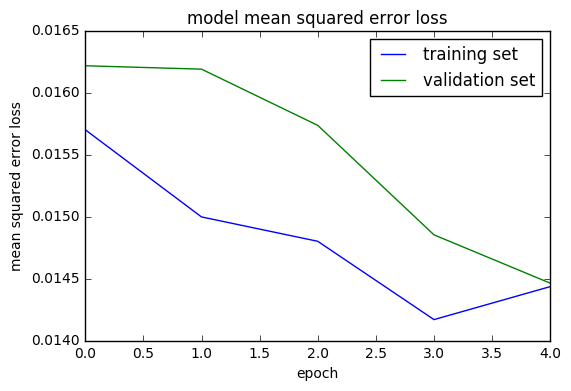

In [12]:
#===============================================================================================
# print some training stats
print(history.history.keys())

# plot the training and validation loss for each epoch
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()

### Saving the trained model

The model is now trained. I was monitoring the training and validation losses as I experimented with different sets of parameters and data set augmentation techniques. If the losses were poor on both training and validation, that would have indicated underfitting. On the other hand, losses low on the training set but poor on the validation set would have indicated overfitting. The trained model is saved using the code snippet below. The model is ready to be used to test drive the simulated car autonomously.

In [13]:
#===============================================================================================
# Save the model and weights
from keras.models import load_model
model.save("./model.h5")
print("Saved model to disk")

Saved model to disk


## Conclusions

I developed a convolutional neural network capable of autonomously controlling the steering angle of a simulated car based on dashboard mounted camera images as input. The model performs well for track-1 in the simulator. Track-2 is challenging, and with dataset acquired manually by driving the car on both tracks, I was able to manage reasonable success on track-2 as well. However track-2 performance is not documented here. Right, now to go take care of my 2-year old, and read [The Gruffalo's Child](http://www.gruffalo.com/world-of/books/gruffalo-books/the-gruffalos-child) over and over until he falls asleep.